# DSCI 573 - Feature and Model Selection

# Lab 4: A mini project - Putting it all together

## Table of contents
0. [Submission instructions](#si) (4%)
1. [Understanding the problem](#1) (4%)
2. [Data splitting](#2) (2%)
3. [EDA](#3) (10%)
4. (Optional) [Feature engineering](#4)
5. [Preprocessing and transformations](#5) (10%)
6. [Baseline model](#6) (2%)
7. [Linear models](#7) (10%)
8. [Different models](#8) (16%)
9. (Optional) [Feature selection](#9)
10. [Hyperparameter optimization](#10) (10%)
11. [Interpretation and feature importances](#11) (10%)
12. [Results on the test set](#12) (10%)
13. [Summary of the results](#13) (12%)
15. (Optional) [Reproducible data analysis pipeline](#14)
15. (Optional) [Your takeaway from the course](#15)

## Submission instructions <a name="si"></a>
<hr>
rubric={mechanics:4}

You will receive marks for correctly submitting this assignment. To submit this assignment, follow the instructions below:

- **Which problem did you pick, classification or regression?** Regression
- **Report your test score here along with the metric used:** TO ADD
- **Please add a link to your GitHub repository here: https://github.ubc.ca/mds-2021-22/DSCI_573_lab4_[]**
- **You don't have to but you may work on this assignment in a group (group size <= 4) and submit your assignment as a group.** 
- Below are some instructions on working as a group.  
    - The maximum group size is 4. 
    - You can choose your own group members. Since I don't know your groups in advance, I am not opening this lab as a group lab. So you all will have a separate GitHub repository for your labs and you'll have to decide how you want to collaborate. 
    - Use group work as an opportunity to collaborate and learn new things from each other. 
    - Be respectful to each other and make sure you understand all the concepts in the assignment well. 
    - It's your responsibility to make sure that the assignment is submitted by one of the group members before the deadline. [Here](https://help.gradescope.com/article/m5qz2xsnjy-student-add-group-members) are some instructions on adding group members in Gradescope.  
- Be sure to follow the [general lab instructions](https://ubc-mds.github.io/resources_pages/general_lab_instructions/).
- Make at least three commits in your lab's GitHub repository.
- Push the final .ipynb file with your solutions to your GitHub repository for this lab.
- Upload the .ipynb file to Gradescope.
- If the .ipynb file is too big or doesn't render on Gradescope for some reason, also upload a pdf or html in addition to the .ipynb. 
- Make sure that your plots/output are rendered properly in Gradescope.

> [Here](https://github.com/UBC-MDS/public/tree/master/rubric) you will find the description of each rubric used in MDS.

> As usual, do not push the data to the repository. 

## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import xgboost as xgb
import shap

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import cross_validate, RandomizedSearchCV
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    power_transform,
    PowerTransformer
)
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from joblib import dump, load

from scipy.stats import uniform, loguniform, randint

## Introduction <a name="in"></a>

In this lab you will be working on an open-ended mini-project, where you will put all the different things you have learned so far in 571 and 573 together to solve an interesting problem.

A few notes and tips when you work on this mini-project: 

#### Tips
1. This mini-project is open-ended, and while working on it, there might be some situations where you'll have to use your own judgment and make your own decisions (as you would be doing when you work as a data scientist). Make sure you explain your decisions whenever necessary. 
2. **Do not include everything you ever tried in your submission** -- it's fine just to have your final code. That said, your code should be reproducible and well-documented. For example, if you chose your hyperparameters based on some hyperparameter optimization experiment, you should leave in the code for that experiment so that someone else could re-run it and obtain the same hyperparameters, rather than mysteriously just setting the hyperparameters to some (carefully chosen) values in your code. 
3. If you realize that you are repeating a lot of code try to organize it in functions. Clear presentation of your code, experiments, and results is the key to be successful in this lab. You may use code from lecture notes or previous lab solutions with appropriate attributions. 

#### Assessment
We plan to grade fairly and leniently. We don't have some secret target score that you need to achieve to get a good grade. **You'll be assessed on demonstration of mastery of course topics, clear presentation, and the quality of your analysis and results.** For example, if you just have a bunch of code and no text or figures, that's not good. If you do a bunch of sane things and get a lower accuracy than your friend, don't sweat it.


#### A final note
Finally, this style of this "project" question is different from other assignments. It'll be up to you to decide when you're "done" -- in fact, this is one of the hardest parts of real projects. But please don't spend WAY too much time on this... perhaps "a few hours" (2-8 hours???) is a good guideline for a typical submission. Of course if you're having fun you're welcome to spend as much time as you want! But, if so, try not to do it out of perfectionism or getting the best possible grade. Do it because you're learning and enjoying it. Students from the past cohorts have found such kind of labs useful and fun and I hope you enjoy it as well. 

<br><br>

## 1. Pick your problem and explain what exactly you are trying to predict <a name="1"></a>
<hr>
rubric={reasoning:4}

In this mini project, you will pick one of the following problems: 

- A classification problem of predicting whether a credit card client will default or not. For this problem, you will use [Default of Credit Card Clients Dataset](https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset). In this data set, there are 30,000 examples and 24 features, and the goal is to estimate whether a person will default (fail to pay) their credit card bills; this column is labeled "default.payment.next.month" in the data. The rest of the columns can be used as features. You may take some ideas and compare your results with [the associated research paper](https://www.sciencedirect.com/science/article/pii/S0957417407006719), which is available through [the UBC library](https://www.library.ubc.ca/). 

OR 

- A regression problem of predicting `reviews_per_month`, as a proxy for the popularity of the listing with [New York City Airbnb listings from 2019 dataset](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data). Airbnb could use this sort of model to predict how popular future listings might be before they are posted, perhaps to help guide hosts create more appealing listings. In reality they might instead use something like vacancy rate or average rating as their target, but we do not have that available here.

**Your tasks:**

1. Spend some time understanding the problem and what each feature means. Write a few sentences on your initial thoughts on the problem and the dataset. 
2. Download the dataset and read it as a pandas dataframe. 
3. Carry out any preliminary preprocessing, if needed (e.g., changing feature names, handling of NaN values etc.)

## Problem Description
We have selected the regression problem for this lab which looks at the New York City Airbnb dataset. Overall, at a high level, the problem is an interesting one with features that seem initially intuitevly relevant to predicting the interest and popularity of Airbnbs in New York ("NYC").

The dataset is from 2019, and the goal is to build a suitable machine learning model that will predict how many reviews per month an Airbnb listing in NYC will get. 

There are 16 columns provided in this dataset with a rich amount of information and diverse features that will require different types of preprocessing. For example, there is a `name` feature that will likely require some NLP processing. Further there are `latitude` and `longitude` features that may also require special pre-processing. In addition, there are a few features that may not be relevant for our problem such as the listing ID (`id`) and the `host_id`. We should also remove the `host_name` feature (the host's name) for ethical and security reasons.

We will being by cleaning up the data with some preliminary preprocessing and handle missing and NaN values.

In [2]:
airbnb_df = pd.read_csv("data/AB_NYC_2019.csv")

In [3]:
airbnb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [4]:
airbnb_df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [5]:
airbnb_df.isna().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

Initial observations:  

- We noticed that there are ~10,000 columns with `NaN` values for our target label `reviews_per_month` and for the `last_review` feature.  Upon further inspection, this appears to be caused when a listing has a value for `number_of_reviews` that is equal to `0`.  In other words, when a listing has no reviews, then it has a `NaN` value in the `reviews_per_month` and `last_review` columns. In order to address this, we will fill these `NaN` values with `0`s, which better represents the values, which are not "missing" `NaN`s.
- Further, there are 16 listings with missing values in `name`, and 21 listings with missing values in `host_name`. As mentioned previously, we will drop the `host_name` feature for ethical reasons as these are associated to names of individuals and should be unimportant to our model. 
- As there are only 16 listings with missing values in `name`, we will also drop these rows.
- We also note that there are ~40k rows of data so dropping these rows would not significantly deplete our dataset.
- At this moment we will include `longitude` and `latitude` as features but may choose to drop it later as we have two other features that correspond to location (`neighbourhood_group` and `neighbourhood`).


In [6]:
airbnb_df["last_review"] = airbnb_df["last_review"].fillna(0)
airbnb_df["reviews_per_month"] = airbnb_df["reviews_per_month"].fillna(0)

airbnb_df = airbnb_df.dropna()

<br><br>

## 2. Data splitting <a name="2"></a>
<hr>
rubric={reasoning:2}

**Your tasks:**

1. Split the data into train and test portions.

> Make decision on the `test_size` based on the capacity of your laptop. Don't forget to use a random state.  

In [7]:
train_df, test_df = train_test_split(airbnb_df, test_size=0.1, random_state=7)

In [8]:
train_df.shape

(43972, 16)

In [9]:
test_df.shape

(4886, 16)

Please note: We have done a 90/10 split so that we can explore a large portion of the data in EDA.  However, when we get to model selection, we have reduced the amount of data that we use to 2,500 rows of data for both the train and test split.  The reason for this is that we attempted to run larger amounts of data, but the non-linear models took forever to run.  At one point we attempted to run a Random Search with 5 fold CV and 50 iterations for a SVR and XGBRegressor with 25k rows of data (this is the equivalent of training 5 * 50 * 2 = 500 non-linear models of 25k rows of data).  We let the search run for 10 hours before cancelling it.  In a real life scenario we would have let the search finish (which we calculated would have taken around 22-24 hours, due to the inefficiency of the SVR model mainly).

<br><br>

## 3. EDA <a name="3"></a>
<hr>
rubric={viz:4,reasoning:6}

**Your tasks:**

1. Perform exploratory data analysis on the train set.
2. Include at least two summary statistics and two visualizations that you find useful, and accompany each one with a sentence explaining it.
3. Summarize your initial observations about the data. 
4. Pick appropriate metric/metrics for assessment. 

## Analysis of numeric features

We first analyse our numeric features and provide some summary statistics of those columns. This will help provide us with some intuition to spot outliers as well as help to familiarise ourselves with the data.

In [10]:
# this removes id, host id, latitude, longitude
numeric = train_df.select_dtypes("number").columns.to_list()[4:]

# present summary of numeric data
round(train_df[numeric].describe().T, 1)

,count,mean,std,min,25%,50%,75%,max
price,43972.0,152.4,236.4,0.0,69.0,106.0,175.0,10000.0
minimum_nights,43972.0,7.0,19.6,1.0,1.0,2.0,5.0,1250.0
number_of_reviews,43972.0,23.3,44.7,0.0,1.0,5.0,24.0,629.0
reviews_per_month,43972.0,1.1,1.6,0.0,0.0,0.4,1.6,58.5
calculated_host_listings_count,43972.0,7.1,32.5,1.0,1.0,1.0,2.0,327.0
availability_365,43972.0,112.8,131.6,0.0,0.0,45.0,227.0,365.0


Above, we have calculated a summary of descriptive statistics for the numerical features in our data.  We can see that:

- There appears to be some significant outliers in the `price` feature, as the max price is $10,000 which is several standard deviations away from the mean.
- There also appears to be significant outliers in the `minimum_nights` feature, as the max value for this feature is 1,250 which is also several standard deviations away from the mean.
- The mean number of `reviews_per_month` (our target) is 1.4 with a standard deviation of 1.7

### Correlation heatmap

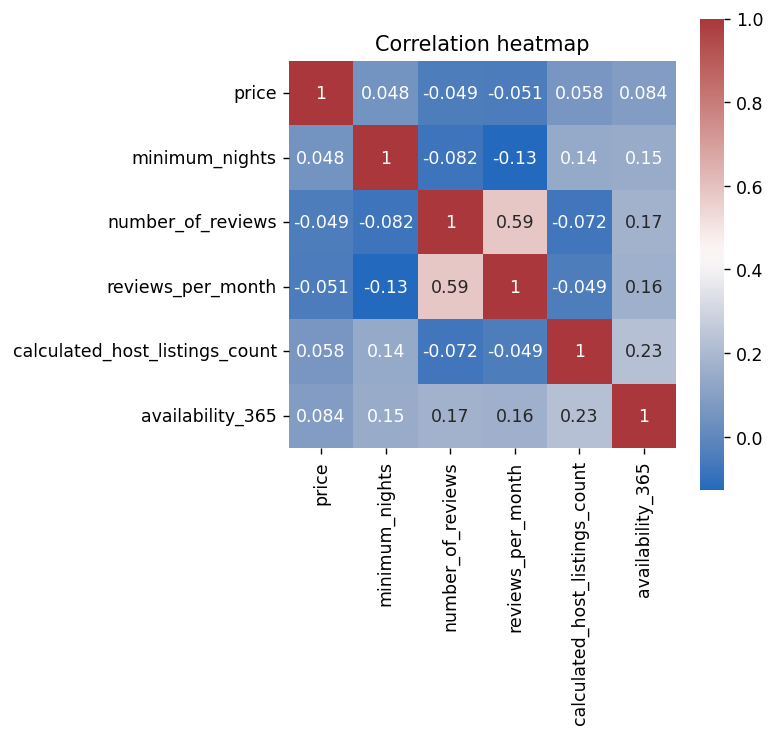

In [11]:
plt.figure(figsize=(5, 5), dpi=125)

sns.heatmap(
    train_df[numeric].corr(),
    cmap="vlag",
    annot=True,
    square=True
).set_title("Correlation heatmap");

In the above correlation heatmap we can see see that:
- For several of the numeric features, there is almost no correlation between them.
- Our target feature `reviews_per_month` is highly correlated with `number_of_reviews` which makes sense, since users with an overall higher number of reviews would be expected to have a higher number of average reviews per month.
- We also note that there is _some_ negative correlation between `reviews_per_month` and `minimum_nights`.


### Distributions of numeric features

In [12]:
def get_axes():
    """Helper funtion for axes for numeric plots"""
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(10, 6), dpi=125)

    axes = [ax1, ax2, ax3, ax4, ax5, ax6]

    return fig, axes

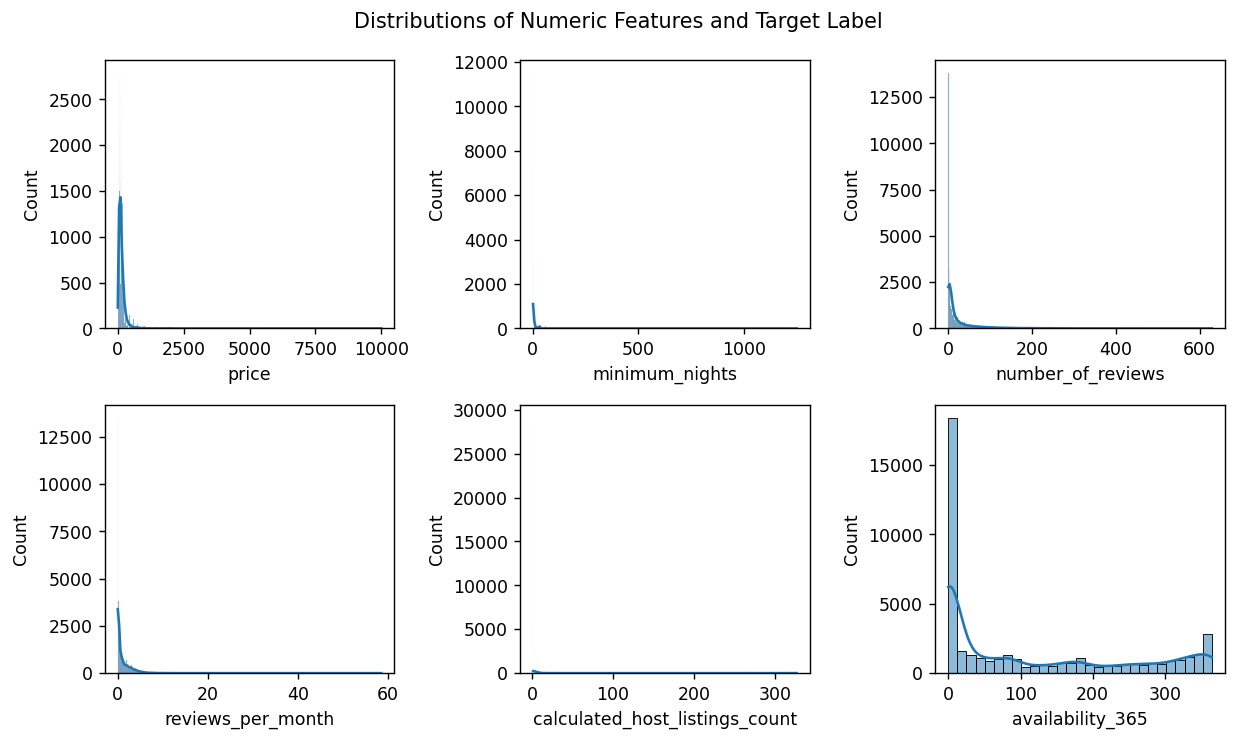

In [13]:
fig, axes = get_axes()

for feat, ax in zip(numeric, axes):
    sns.histplot(train_df, x=feat, kde=True, ax=ax)

plt.suptitle("Distributions of Numeric Features and Target Label")
plt.tight_layout()

Based on the plot of the distributions of the numeric features we can see that except for the feature `availability_365`, the remaining features are all significantly skewed to the right.  We can consider how to fix this in feature engineering.

Further, we also note that our target label `reviews_per_month` is also quite skewed to the right.

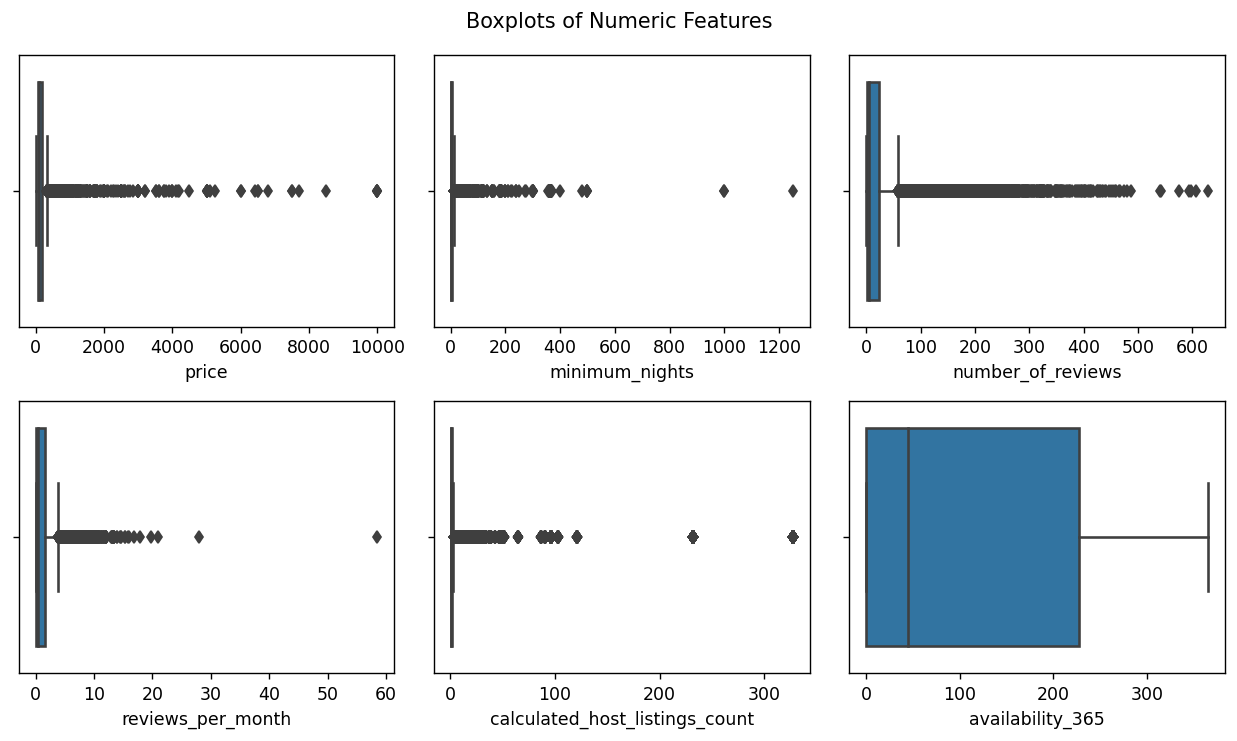

In [14]:
fig, axes = get_axes()

for feat, ax in zip(numeric, axes):
    sns.boxplot(x=train_df[feat], ax=ax)

plt.suptitle("Boxplots of Numeric Features")
plt.tight_layout()

The boxplots above help further identify how skewed the distribution of our numeric features and target label are.

### Outlier analysis

In [15]:
# calculate interquartile range
Q1 = train_df[numeric].quantile(0.25)
Q3 = train_df[numeric].quantile(0.75)
IQR = Q3 - Q1

# get outliers based on IQR
outliers = Q3 + 1.5 * IQR

# summary of outliers in each numeric feature
print("Outliers in numeric features")
for feat in numeric:
    feat_outliers = (train_df[feat] > outliers[feat]).sum()
    print(f"{feat_outliers} in {feat}")

Outliers in numeric features
2669 in price
5946 in minimum_nights
5423 in number_of_reviews
2992 in reviews_per_month
6376 in calculated_host_listings_count
0 in availability_365


In [16]:
outlier_idx = set(train_df.index)

for feat in ["number_of_reviews", "minimum_nights"]:
    outlier_idx = outlier_idx.intersection(
        set(train_df[train_df[feat] > outliers[feat]].index))

print(f"Common outliers in review features: {len(outlier_idx)}")
print(f"Percentange of data: {len(outlier_idx) / len(train_df):02f}")

Common outliers in review features: 184
Percentange of data: 0.004184


We can see that there are varying numbers of outliers in each of our numeric features.  Something of note is that the `number_of_reviews` and `minimum_nights` appear to have 184 outliers in common.  Given the size of our dataset, we will drop these rows in order to remove some of the outliers in our data.

In [17]:
train_df = train_df.drop(outlier_idx)

In [18]:
target_outliers = set(train_df.query("reviews_per_month > 10").index)
len(target_outliers)

77

In [19]:
train_df = train_df.drop(target_outliers)

## Analysis of categorical features


Here we analyse the categorical features `neighbourhood_group`, `neighbourhood`, `room_type` and provide some data visualisations on the geo-locations of the Airbnb.

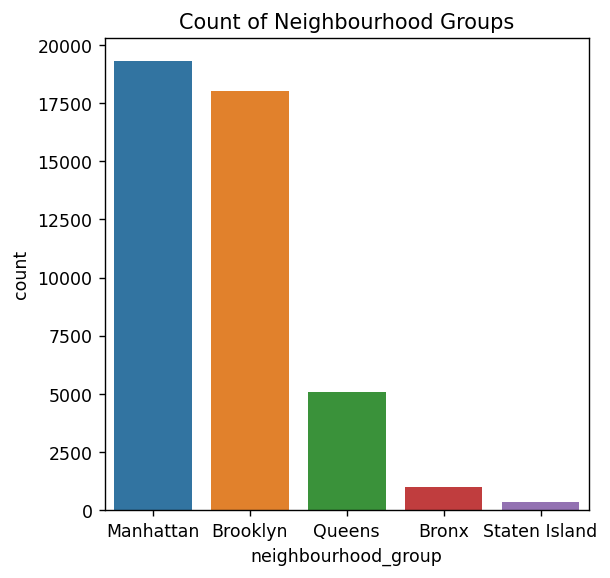

In [20]:
plt.figure(figsize=(5, 5), dpi=125)

sns.countplot(
    x="neighbourhood_group",
    data=train_df,
    order=train_df["neighbourhood_group"].value_counts().index
).set_title("Count of Neighbourhood Groups");

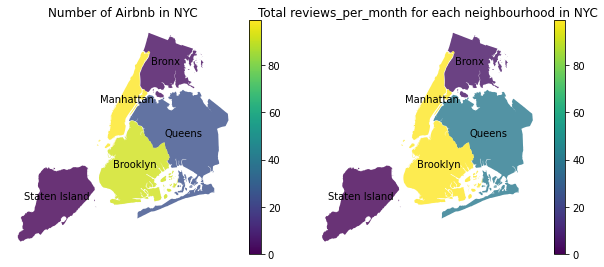

In [21]:
nyc = gpd.read_file(gpd.datasets.get_path('nybb'))

borough_count = airbnb_df.groupby('neighbourhood_group').agg('count').reset_index()
borough_sum = airbnb_df.groupby('neighbourhood_group').agg('sum').reset_index()

nyc.rename(columns={'BoroName':'neighbourhood_group'}, inplace=True)
bc_geo = nyc.merge(borough_count, on='neighbourhood_group')
bc_geo_sum = nyc.merge(borough_sum, on='neighbourhood_group')

plot_data = [{'dataset': bc_geo,
        'title': 'Number of Airbnb in NYC',
        'column': 'id'}, 
        {'dataset': bc_geo_sum,
        'title': 'Total reviews_per_month for each neighbourhood in NYC',
        'column': 'reviews_per_month'}]

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,10))
im = ax.imshow(np.arange(100).reshape((10,10)))


for col in range(2):
    ax = axs[col]
    plot_data[col]['dataset'].plot(column=plot_data[col]['column'], ax=ax, alpha=.8)
    plot_data[col]['dataset'].apply(lambda x: ax.annotate(text=x.neighbourhood_group, xy=x.geometry.centroid.coords[0],ha='center'), axis=1)      
    ax.set_title(plot_data[col]['title'])
    ax.axis('off')
    plt.colorbar(im,fraction=0.046, pad=0.04, ax=ax)
plt.show()


These two plots highlight the number of Airbnbs for each neighbourhood in NYC. The map helps us to visualise the location and give us more geographical context to the neighbourhoods which may help later when qualitatively discussing results.  
We can see the number of Airbnbs and the `review_per_month` for each neighbourhood side by side. Note that the colours show that there seem to be more reviews in Queens and Brooklyn relative to the other neighbourhoods.

Additionally we see a more straight-forward plot of the counts of Airbnbs below - we see that Manhatten and Brooklyn have an abundance of Airbnbs.

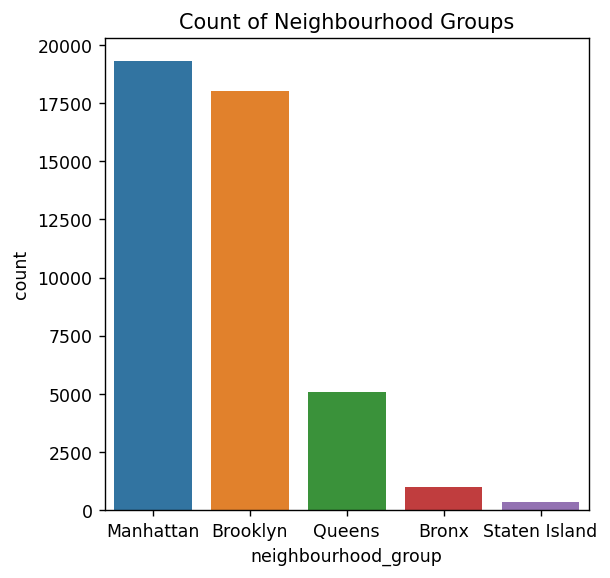

In [22]:
plt.figure(figsize=(5, 5), dpi=125)

sns.countplot(
    x="neighbourhood_group",
    data=train_df,
    order=train_df["neighbourhood_group"].value_counts().index
).set_title("Count of Neighbourhood Groups");

We also look at the value distribution of `room_type` for the Airbnbs:

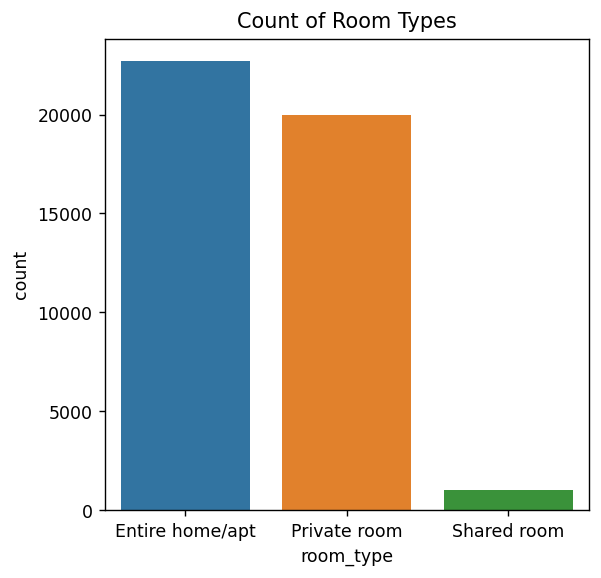

In [23]:
plt.figure(figsize=(5, 5), dpi=125)

sns.countplot(
    x="room_type",
    data=train_df,
    order=train_df["room_type"].value_counts().index
).set_title("Count of Room Types");

### `name` Feature
In addition to these feature we explore NLP processing on the `name` feature.
This part pre-emptively explains why we have decided to drop this feature in our model.

In [24]:
train_df['name'] = train_df['name'].fillna('None')

lengths = train_df["name"].str.len().to_numpy()

longest = lengths.argmax()
shortest = lengths.argmin()
average = lengths.mean()

print(f"Shortest name: ",train_df["name"].iloc[shortest])
print(f"Longest name: ",train_df["name"].iloc[longest])
print(f"Average length:", average)

Shortest name:  X
Longest name:  The printing studio bedroom with garden in Bedstuy  !!Brooklyn. Historic neighborhood close to everything ! Full kitchen bathroom BBQ and porch at your disposal. Learn to print !!
Average length: 36.9094964654206


In [25]:
vec = CountVectorizer(stop_words="english", max_features=20)
X_counts = vec.fit_transform(train_df["name"])

In [26]:
pd.DataFrame(
    data=X_counts.sum(axis=0).tolist()[0],
    index=vec.get_feature_names_out(),
    columns=["counts"],
).sort_values("counts", ascending=False)

,counts
room,9196
bedroom,7321
private,6621
apartment,6057
cozy,4561
apt,4253
brooklyn,3736
studio,3671
spacious,3396
manhattan,3230


There was an option for us to continue to use this feature and optimise the hyperparameter `max_features` as well as `binary` for the CountVectoriser. However, we found that adding more dimensions to our features caused the training to take an exorbitant amount of time.
These features would also need to be preprocessed further to remove special characters. 
Additionally, from this table we can also see that some words are neighbourhood names which are already encoded in our `neighbourhood` feature. 

For these reasons we have decided to drop `name` as a feature for this model.

## (Optional) 4. Feature engineering <a name="4"></a>
<hr>
rubric={reasoning:1}

**Your tasks:**

1. Carry out feature engineering. In other words, extract new features relevant for the problem and work with your new feature set in the following exercises. You may have to go back and forth between feature engineering and preprocessing. 

## Numerical features - transformations

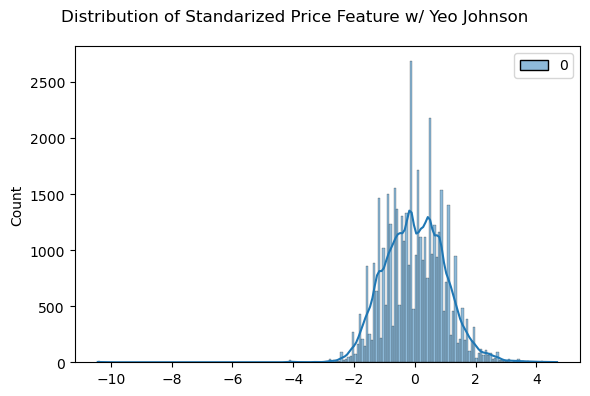

In [27]:
plt.figure(figsize=(6, 4), dpi=100)

sns.histplot(
    power_transform(
        train_df["price"].to_numpy().reshape(-1, 1),
        standardize=True),
    kde=True
)
plt.suptitle("Distribution of Standarized Price Feature w/ Yeo Johnson")
plt.tight_layout()

- Above, we have applied the yeo-johnson transformation to the price feature
- We can see that this makes the distribution quite normal.
- We will build this transformation into our column transformer.

## Numerical features - binning

Below, we have created a custom categorical class that creates new values based on the numerical values of the inputs, I.e. we have chosen to group certain ranges of values and label them to encode more context that we think is relevant to predicting the number of reviews per month.
This will be applied to three features:
- `minimum_nights`
- `number_of_reviews`
- `calculated_host_listings_count`  
From the EDA, we found that the distribution of these values were heavily skewed and would not be appropriate to scale without either further transformation. We have decided that to categorize certain ranges of these values in order to retain some contextual information of the features.


In [28]:
class CustomCatFeatures(BaseEstimator, TransformerMixin):
    """Custom sklearn transformer for feature engineering the airbnb dataset"""

    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def __transform_minimum_nights(self, x):
        """Bins minimum nights into categorical feature"""
        if 0 <= x <= 3:
            return "short_term_stay"
        elif 3 < x <= 7:
            return "medium_term_stay"
        else:
            return "long_term_stay"

    def __transform_number_of_reviews(self, x):
        """Bins number_f_reviews into categorical feature"""
        if 0 <= x < 10:
            return "less_than_10_reviews"
        elif 10 < x <= 50:
            return "11_to_50_reviews"
        elif 50 < x <= 100:
            return "51_to_100_reviews"
        else:
            return "100+ reviews"

    def __transform_host_listings(self, x):
        """Bins host listings into categorical feature"""
        if x == 1:
            return "1_listing"
        else:
            return "2+_listings"

    def transform(self, X, y=1):
        X = X.copy()

        X["minimum_nights"] = X["minimum_nights"].apply(self.__transform_minimum_nights)
        X["number_of_reviews"] = X["number_of_reviews"].apply(self.__transform_number_of_reviews)
        X["calculated_host_listings_count"] = X["calculated_host_listings_count"].apply(self.__transform_host_listings)

        return X

In [29]:
## TODO: write tests for CustomCatFeatures
dummy_data = pd.DataFrame(data={
    'minimum_nights' : [0, 4, 6, 1, 5, 13, 21, 4, 2, 16],
    'number_of_reviews' : [0, 20, 130, 23, 55, 0, 109, 78, 16, 7],
    'calculated_host_listings_count' : [1, 5, 6, 2, 1, 1, 2, 4, 5, 1]
})

## 5. Preprocessing and transformations <a name="5"></a>
<hr>
rubric={accuracy:6,reasoning:4}

**Your tasks:**

1. Identify different feature types and the transformations you would apply on each feature type. 
2. Define a column transformer, if necessary. 

In [30]:
X_train = train_df.drop(columns=["reviews_per_month"])
y_train = train_df["reviews_per_month"]

X_test = test_df.drop(columns=["reviews_per_month"])
y_test = test_df["reviews_per_month"]

In [31]:
# We take a slice of the data here to speed up training
# As discussed earlier in our notebook
X_train = X_train[:2500]
y_train = y_train[:2500]

X_test = X_test[:2500]
y_test = y_test[:2500]

In [32]:
drop_feat = [
    "id",
    "host_id",
    "host_name",
    "name",
    "latitude",
    "longitude",
    "last_review",
    "availability_365"
]

cat_feat = [
    "neighbourhood_group",
    "neighbourhood",
    "room_type"
]

num_feat = [
    "price"
]

custom_cat_feats = [
    "minimum_nights",
    "number_of_reviews",
    "calculated_host_listings_count",

]


assert set(drop_feat + cat_feat + num_feat + custom_cat_feats) == set(X_train.columns)

### Dropped features:
- `longitude` and `latitude`: From the EDA we have to decided to drop longitude and latitude based on the fact that we have geographical boundaries encoded by the `neighbourhood_group` and `neighbourhood` features.
- `availability_365` is the amount of days out of the year when listing is available for booking. We could potentially feature engineer and create categorical values, however, having investigated the distribution of this feature and found many Airbnbs that were _not_ or rarely available. we have decided that it may not be too relevant of a feature and so will discard it.
- `last_review` is the date of the most recent review. We will be dropping this feature for now. We initially planned to take the number of days from the last reviewed to "now" and bin the values for one-hot-encoding, however we the values with 0 would cause issues in the processing. We may revisit this feature if we have time.
- `host_id`,`id`: These are features that have no contextual relevance so can be removed
- `host_name`: Mentioned previously, this should be removed for ethical reasons
- `name`: As mentioned in EDA we have decided to remove this feature.

### Categorical features:
- `neighbourhood_group`: 5 values
- `neighbourhood`: 221 values
- `room_type`  : 3 values  
From our EDA we have shown the variety of values that are part of these categorical features. We are choosing to keep them all and one hot encoding them

### Numerical features:
- `price`: we will be scaling this feature and applying the yeo-johnson transformation

### Custom features:
- `minimum_nights`
- `number_of_reviews`
- `calculated_host_listings_count`  
These features are numerical, however, we have decided to turn them into categorical features with values that still hold information on the raw data, and helps to understand the outputs contextually. This is due to the skewness of the distribution of these features which was explored in the EDA. 


In [33]:
custom_transformer = make_pipeline(
    CustomCatFeatures(),
    OneHotEncoder(handle_unknown="ignore", sparse=False)
)

preprocessor = make_column_transformer(
    ("drop", drop_feat),
    (OneHotEncoder(handle_unknown="ignore", sparse=False), cat_feat),
    (PowerTransformer(standardize=True), num_feat),
    (custom_transformer, custom_cat_feats),
)


In [34]:
# TODO: consider deleting, in practice we wouldn't do this due to dimensionality
preprocessor.fit(X_train)

feat_names = (
    preprocessor.named_transformers_["onehotencoder"].get_feature_names_out().tolist()
    + num_feat
    + preprocessor.named_transformers_["pipeline"].named_steps["onehotencoder"].get_feature_names_out().tolist()
)

X_train.index


X_train_enc = pd.DataFrame(
    preprocessor.transform(X_train),
    index=X_train.index,
    columns=feat_names
)

X_train_enc.shape

(2500, 177)

<br><br>

## 6. Baseline model <a name="6"></a>
<hr>
rubric={accuracy:2}

**Your tasks:**
1. Try `scikit-learn`'s baseline model and report results.

In [35]:
dummy = DummyRegressor()

In [36]:
def get_mean_cv_scores(model, X_train, y_train, **kwargs):
    """Calculates and returns the mean cross validation score for a model.
    Parameters
    ----------
    model : sklearn estimator or xgb model
        The model to cross validate
    X_train : numpy ndarray
        The feature matrix
    y_train : numpy ndarray
        The target labels
    Returns
    -------
    pandas Series
        The mean cross validation scores with standard deviations
    """
    output = []

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()

    # present scores as score (+/- sd)
    for i in range(len(mean_scores)):
        output.append(f"{mean_scores[i]:.2f} (+/- {std_scores[i]:.2f})")

    return pd.Series(data=output, index=mean_scores.index)

In [37]:
results = {}

results["dummy"]  = get_mean_cv_scores(
    dummy, X_train, y_train, return_train_score=True, scoring="neg_mean_squared_error"
)

pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
dummy,0.00 (+/- 0.00),0.00 (+/- 0.00),-2.23 (+/- 0.24),-2.23 (+/- 0.06)


We will use root mean squared error as the main metric to assess our model.  We will also calculate $R^2$ scores to asses how much of the variance our model is able to explain.

<br><br>

## 7. Linear models <a name="7"></a>
<hr>
rubric={accuracy:6,reasoning:4}

**Your tasks:**

1. Try a linear model as a first real attempt. 
2. Carry out hyperparameter tuning to explore different values for the regularization hyperparameter. 
3. Report cross-validation scores along with standard deviation. 
4. Summarize your results.

In [38]:
linear_models = {
    "Ridge": Ridge(),
    "SVR_linear": SVR(kernel="linear")
}

In [39]:
for name, model in linear_models.items():
    pipe = make_pipeline(preprocessor, model)
    
    results[name] = get_mean_cv_scores(
        pipe, X_train, y_train, return_train_score=True, scoring="neg_mean_squared_error"
    )

pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
dummy,0.00 (+/- 0.00),0.00 (+/- 0.00),-2.23 (+/- 0.24),-2.23 (+/- 0.06)
Ridge,0.02 (+/- 0.01),0.00 (+/- 0.00),-1.30 (+/- 0.07),-1.13 (+/- 0.01)
SVR_linear,0.28 (+/- 0.01),0.04 (+/- 0.00),-1.43 (+/- 0.10),-1.33 (+/- 0.02)


In [40]:
ridge_cv_pipe = make_pipeline(preprocessor, RidgeCV(cv=10))

results["Ridge_tuned"] = get_mean_cv_scores(
    ridge_cv_pipe, X_train, y_train, return_train_score=True, scoring="neg_mean_squared_error"
)

ridge_cv_pipe.fit(X_train, y_train)

pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
dummy,0.00 (+/- 0.00),0.00 (+/- 0.00),-2.23 (+/- 0.24),-2.23 (+/- 0.06)
Ridge,0.02 (+/- 0.01),0.00 (+/- 0.00),-1.30 (+/- 0.07),-1.13 (+/- 0.01)
SVR_linear,0.28 (+/- 0.01),0.04 (+/- 0.00),-1.43 (+/- 0.10),-1.33 (+/- 0.02)
Ridge_tuned,0.14 (+/- 0.01),0.00 (+/- 0.00),-1.29 (+/- 0.07),-1.17 (+/- 0.03)


We have used Ridge and an SVR with linear kernel as our linear regression models. We can see that these linear regressions perform better than our dummy model giving us a test score of -1.30 and -1.43 respectively with Ridge performing better than the linear SVR.

Using `RidgeCV`, it automatically tunes our model and picks an optimal hyperparameter `alpha` by cross-validation. We see here that we get a marginally better score of -1.29.
Additionally, the fit time for `RidgeCV()` takes longer due to the cross-validation but not as long as the linear SVR model.

In [41]:
print(f'best alpha:', ridge_cv_pipe.named_steps["ridgecv"].alpha_)

best alpha: 10.0


After being fit on the training set, the `RidgeCV` model gives us an optimal hyperparameter of alpha=10. We will explore more values for alpha in the hyperparameter tuning section later.

<br><br>

## 8. Different models <a name="8"></a>
<hr>
rubric={accuracy:10,reasoning:6}

**Your tasks:**
1. Try at least 3 other models aside from a linear model. 
2. Summarize your results in terms of overfitting/underfitting and fit and score times. Can you beat a linear model? 

We compare our linear model with 3 different models: 
- KNeighborsRegressor
- SVR
- XGB


In [42]:
non_linear_models = {
    "KNN": KNeighborsRegressor(),
    "SVR": SVR(),
    "XGB": xgb.XGBRegressor(verbosity=0)
}

In [43]:
for name, model in non_linear_models.items():
    pipe = make_pipeline(preprocessor, model)

    results[name] = get_mean_cv_scores(
        pipe, X_train, y_train, return_train_score=True, scoring="neg_mean_squared_error"
    )

pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
dummy,0.00 (+/- 0.00),0.00 (+/- 0.00),-2.23 (+/- 0.24),-2.23 (+/- 0.06)
Ridge,0.02 (+/- 0.01),0.00 (+/- 0.00),-1.30 (+/- 0.07),-1.13 (+/- 0.01)
SVR_linear,0.28 (+/- 0.01),0.04 (+/- 0.00),-1.43 (+/- 0.10),-1.33 (+/- 0.02)
Ridge_tuned,0.14 (+/- 0.01),0.00 (+/- 0.00),-1.29 (+/- 0.07),-1.17 (+/- 0.03)
KNN,0.01 (+/- 0.00),0.02 (+/- 0.00),-1.53 (+/- 0.16),-1.01 (+/- 0.02)
SVR,0.26 (+/- 0.01),0.11 (+/- 0.00),-1.37 (+/- 0.10),-1.16 (+/- 0.03)
XGB,0.36 (+/- 0.01),0.01 (+/- 0.00),-1.44 (+/- 0.08),-0.51 (+/- 0.02)


From the results table we see that all models outperform the dummy model and the tuned Ridge model still performs best with the greatest test score.

KNN, SVR and XGB have scores of -1.52, -1.38 and -1.42 respectively.  
We also see that there is more over-fitting from the XGB model as the results table shows a larger difference in train and test scores. Similarly, there is also over-fitting from the KNN and SVR models.  

There may be some under-fitting with the Ridge-tuned model due to the smaller difference in scores.

In terms of fit time, these models take longer than the Ridge model which is as expected. The linear SVR still takes the longest time to fit (0.41s0, along with the SVR with RGF kernel and XGB models that take 0.29s and 0.37s respectively.

In summary, the linear Ridge model performs best.

<br><br>

## (Optional) 9. Feature selection <a name="9"></a>
<hr>
rubric={reasoning:1}

**Your tasks:**

Make some attempts to select relevant features. You may try `RFECV`, forward selection or L1 regularization for this. Do the results improve with feature selection? Summarize your results. If you see improvements in the results, keep feature selection in your pipeline. If not, you may abandon it in the next exercises. 

<br><br>

## 10. Hyperparameter optimization <a name="10"></a>
<hr>
rubric={accuracy:6,reasoning:4}

**Your tasks:**

Make some attempts to optimize hyperparameters for the models you've tried and summarize your results. In at least one case you should be optimizing multiple hyperparameters for a single model. You may use `sklearn`'s methods for hyperparameter optimization or fancier Bayesian optimization methods. 
  - [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)   
  - [RandomizedSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)
  - [scikit-optimize](https://github.com/scikit-optimize/scikit-optimize) 

In this section, we will tune the hyperparameters of the `SVR` with an `rbf` kernel, and the `XGBRegressor`.  We opted not to tune the KNN, due to the very poor performance on the validation sets in cross validation.

In [44]:
pipes = {
    "SVR": make_pipeline(preprocessor, SVR()),
    "XGB": make_pipeline(preprocessor, xgb.XGBRegressor(verbosity=0))
}

In [45]:
svr_search_space = {
    "svr__C": uniform(0.001, 1e4),
    "svr__gamma": ["scale", "auto"]
}

xgb_search_space = {
    "xgbregressor__n_estimators": randint(50, 350),
    "xgbregressor__max_depth": np.arange(4, 8),
    "xgbregressor__learning_rate": loguniform(0.3, 0.5),
}

search_spaces = [svr_search_space, xgb_search_space]

In [46]:
random_searches = {}

for name, pipe, search_space in zip(pipes.keys(), pipes.values(), search_spaces):
    random_search = RandomizedSearchCV(
        pipe,
        search_space,
        n_iter=50,
        n_jobs=-1,
        random_state=7,
        scoring="neg_mean_squared_error"
    )

    random_searches[name + "_tuned"] = random_search.fit(X_train, y_train)

In [51]:
print("Best MSE")
for name, search in random_searches.items():
    results[name] = {'test_score': round(search.best_score_, 2)}
    print(f"Model {name}: {search.best_score_:.02f}")

Best MSE
Model SVR_tuned: -1.38
Model XGB_tuned: -1.36


In [55]:
pd.DataFrame(results).T['test_score']

dummy          -2.23 (+/- 0.24)
Ridge          -1.30 (+/- 0.07)
SVR_linear     -1.43 (+/- 0.10)
Ridge_tuned    -1.29 (+/- 0.07)
KNN            -1.53 (+/- 0.16)
SVR            -1.37 (+/- 0.10)
XGB            -1.44 (+/- 0.08)
SVR_tuned                 -1.38
XGB_tuned                 -1.36
Name: test_score, dtype: object

We see that after performing random search CV for hyperparameter optimisation that the scores for SVR has become slightly worse with a test score of -1.38. 
For XGB, the tuned model has improved slightly to -1.36. However based on the standard deviations of the un-tuned models, these scores lie within this range so it's unclear in this particular case to say that the hyperparameter optimisation has been successful.

There are a few reasons why the optimisation hasn't performed well:
- We are cross-validating with only 50 iterations - this is not enough to tune our model
- RandomisedSearchCV may have selected the best scores out of randomly chosen and worse-performing cross validation scores
- For reasons mentioned previously, we are also using 2500 rows of data which may not be sufficient enough to tune the models

<br><br>

## 11. Interpretation and feature importances <a name="1"></a>
<hr>
rubric={accuracy:6,reasoning:4}

**Your tasks:**

1. Use the methods we saw in class (e.g., `eli5`, `shap`), or any other methods of your choice, to examine the most important features of one of the non-linear models. 
2. Summarize your observations. 

In [56]:
X_train_enc = pd.DataFrame(
    preprocessor.transform(X_train),
    index=X_train.index,
    columns=feat_names
)

X_train_enc.shape

(2500, 177)

In [57]:
X_test_enc = pd.DataFrame(
    preprocessor.transform(X_test),
    index=X_test.index,
    columns=feat_names
)

X_train_enc.shape

(2500, 177)

In [58]:
pipe_xgb = random_searches["XGB_tuned"].best_estimator_

xgb_explainer = shap.TreeExplainer(pipe_xgb.named_steps["xgbregressor"])

train_xgb_shap_values = xgb_explainer.shap_values(X_train_enc)
test_xgb_shap_values = xgb_explainer.shap_values(X_test_enc)

In [59]:
train_xgb_shap_values.shape

(2500, 177)

In [60]:
test_xgb_shap_values.shape

(2500, 177)

In [61]:
shap.initjs()

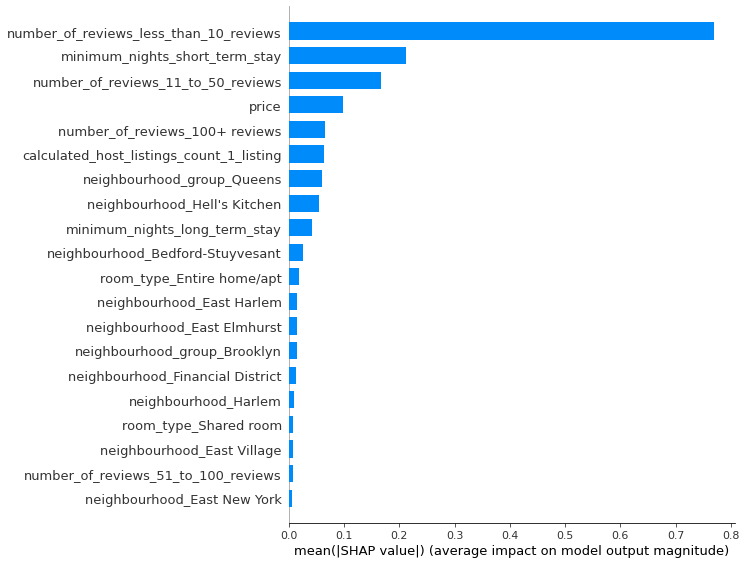

In [62]:
shap.summary_plot(train_xgb_shap_values, X_train_enc, plot_type="bar")

Here we display a chart of the global feature importances from our model:

- We see that `number_of_reviews_less_than_10_reviews` comes up as a significantly important feature and has the greatest SHAP magnitude.
- `minimum_nights_short_term_stay` and `number_of_reviews_11_to_50_reviews` and `pice` are also features that have some importance
- `neighbourhood_` features seem to be less important in the model prediction.

Contextually, it might make sense that `minimum_nights_short_term_stay` is an important feature given that it could be associated to a greater number of different users renting and therefore affects the number of reviews received. 

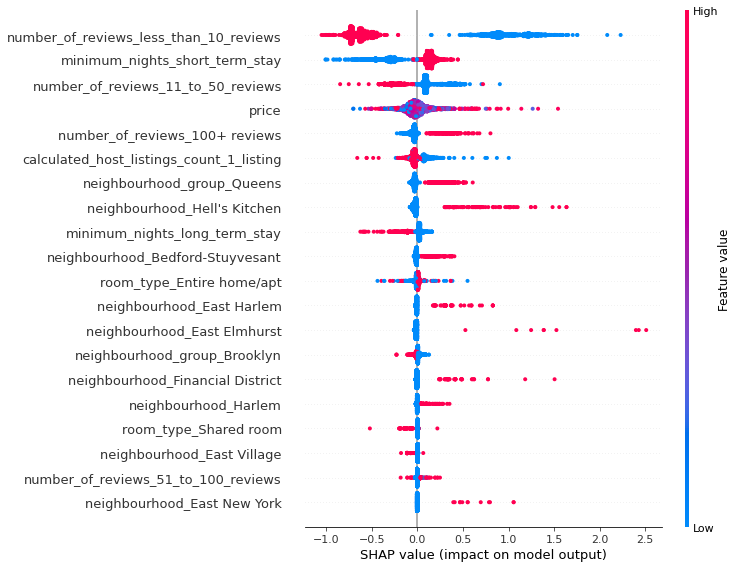

In [63]:
shap.summary_plot(train_xgb_shap_values, X_train_enc)

In addition to the importance plot, we can see the direction of which the feature is driving the prediction. From the above plot we can see that:
- `number_of_reviews_less_than_10_reviews` : is associated to both high and low predictions, where a low value of this feature corresponds to 
a higher SHAP value and therefore greater impact on the model prediction - i.e. in context a lower feature value will push the model towards predicting a much higher `review_per_month` value. 
- `minimum_nights_short_term_stay`: Higher values of this feature is associated to positive SHAP value and therefore is likely to have a small positive change on the predicted value.
- `neighbourhood_`: For these features, if they have a low feature value it results in no impact to the model prediction, whereas a higher value could have a positive or negative impact on the model output.

<br><br>

## 12. Results on the test set <a name="12"></a>
<hr>

rubric={accuracy:6,reasoning:4}

**Your tasks:**

1. Try your best performing model on the test data and report test scores. 
2. Do the test scores agree with the validation scores from before? To what extent do you trust your results? Do you think you've had issues with optimization bias? 
3. Take one or two test predictions and explain them with SHAP force plots.  

In [64]:
final_model = pipe_xgb

In [65]:
y_pred = final_model.predict(X_test)

final_score = mean_squared_error(y_test, y_pred)

final_score

1.4194874613696828

Our best non-linear model was the XGboost regression model.  The final mean squared error is 1.42 on the test set.  The best negative mean squared error achieved during the Random Search was -1.36.  To compare this to the test MSE we can convert it to a positive number, 1.36.  Therefore the model is performing quite similar on the test set compared to the validation sets in the randomized CV.  We don't think there is issues with optimization bias.  However, as we only used 2.5k training instances, our model could have likely performed better with more data.

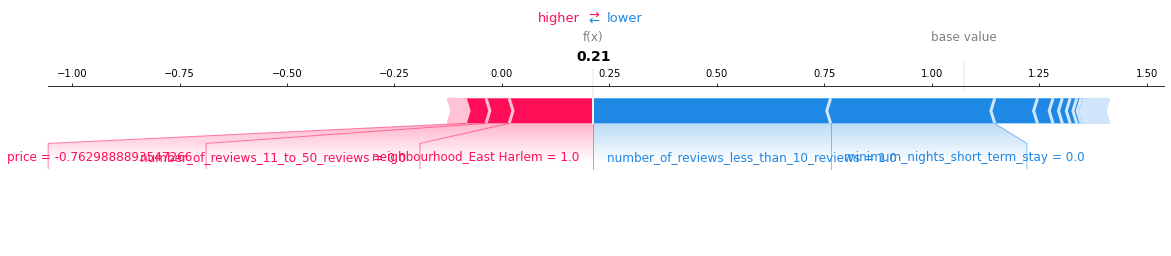

In [66]:
shap.force_plot(
    xgb_explainer.expected_value,
    test_xgb_shap_values[8],
    X_test_enc.iloc[8, :],
    matplotlib=True,
)

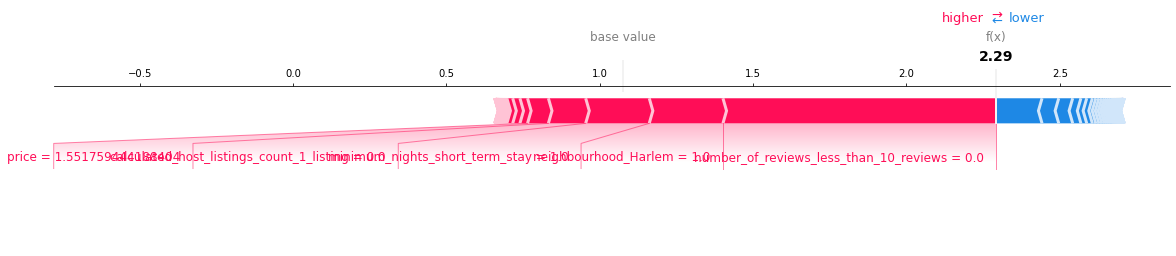

In [67]:
shap.force_plot(
    xgb_explainer.expected_value,
    test_xgb_shap_values[100],
    X_test_enc.iloc[100, :],
    matplotlib=True,
)

In both shap plots, we can see that the feature that impacts the predictions the most is `number_of_reviews_less_than_10_reviews`.  This is intuitive since if a airbnb has more or less than 10 reviews, then we would expect the monthly reviews to either be low or high respectively

<br><br>

## 13. Summary of results <a name="13"></a>
<hr>
rubric={reasoning:12}

Imagine that you want to present the summary of these results to your boss and co-workers. 

**Your tasks:**

1. Create a table summarizing important results. 
2. Write concluding remarks.
3. Discuss other ideas that you did not try but could potentially improve the performance/interpretability . 
3. Report your final test score along with the metric you used at the top of this notebook in the [Submission instructions section](#si).

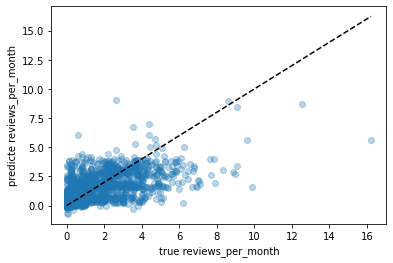

In [68]:
plt.scatter(y_test, y_pred, alpha=0.3)
grid = np.linspace(y_test.min(), y_test.max(), 1000)
plt.plot(grid, grid, "--k")
plt.xlabel("true reviews_per_month")
plt.ylabel("predicte reviews_per_month");

From this plot we show how our model has performed on the test set. We see that with more points below the 45 line, our model is under predicting and performs poorly for larger numbers of reviews per month.  This is likely due to the limited amount of data that we used.

### Table of results

| Syntax      | Description |
| ----------- | ----------- |
| Header      | Title       |
| Paragraph   | Text        |

### Improvements
There are some improvements that we could make with our model, in particular:
- Continuing from what was mentioned in our EDA about removing the CountVectorisation of the `name` feature due. Having more time to pre-process this particular text feature could be interesting to explore.
- In addition, we chose to categorise a few features during our feature engineering... not sure if we want to consider keeping this feature as numerical and scaling.
- If we had more time, we could train our models with the full amount of data, this would provide more examples to our models, and allow them to learn more nuance about our problem which may result in better predictions
- Another possible way to improve would be to try to use a voting or stacked model

### Interpretability
From the SHAP plots we can summarise that the number of reviews, short term stays and price come up as the top few features. Contextually this does make sense as we'd expect this to be more correlated to our target.
There's likely to be some inter-relationship between short term stays, number of reviews and price which would be interesting to explore further. 

### Final score

In [69]:
print("Final MSE")
round(final_score, 2)

Final MSE


1.42

<br><br>

## (Optional) 14. Creating a data analysis pipeline <a name="14"></a>
rubric={reasoning:2}

**Your tasks:**
- In 522 you learned how build a reproducible data analysis pipeline. Convert this notebook into scripts and create a reproducible data analysis pipeline with appropriate documentation. 

<br><br>

## (Optional) 15. Your takeaway from the course <a name="15"></a>
<hr>
rubric={reasoning:1}

**Your tasks:**

What is your biggest takeaway from this course? 

For complex non-linear models, machine learning can be very hard to interpret/explain.
Using SHAP to interpret features and understand how they influence model predictions is also very interesting as it helps us to determine the relationship between the value of a feature and the impact on the prediction. 
Additionally, feature selection is not an easy task and there are many factors to consider in regards to balancing the fundamental trade off and achieving a fast training model.

<br><br>

**PLEASE READ BEFORE YOU SUBMIT:** 

When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from "1" will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Push all your work to your GitHub lab repository. 
4. Upload the assignment using Gradescope's drag and drop tool. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission. 
5. Make sure that the plots and output are rendered properly in your submitted file. If the .ipynb file is too big and doesn't render on Gradescope, also upload a pdf or html in addition to the .ipynb so that the TAs can view your submission on Gradescope. 

Well done!! Have a great weekend! 

In [ ]:
# from IPython.display import Image

# Image("eva-well-done.png")